In [371]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [372]:
# Load the dataset
housing = pd.read_csv("dataset.csv")
target_name = "Price"
data = housing.drop(columns=target_name)
target = housing[target_name]

print(f"Dataset size: {data.shape}")

Dataset size: (13580, 20)


### Columns description
**Rooms**: Number of rooms
**Price**: Price in dollars
**Method**: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
**Type**: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
**SellerG**: Real Estate Agent
**Date**: Date sold
**Distance**: Distance from CBD
**Regionname**: General Region (West, North West, North, North east …etc)
**Propertycount**: Number of properties that exist in the suburb.
**Bedroom2**: Scraped # of Bedrooms (from different source)
**Bathroom**: Number of Bathrooms
**Car**: Number of carspots
**Landsize**: Land Size
**BuildingArea**: Building Size
**CouncilArea**: Governing council for the area

In [373]:
numerical_features = ["Rooms", "Distance", "Propertycount", "Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea"]

categorical_features = ["Type", "SellerG", "Regionname", "CouncilArea"]

data = data[numerical_features + categorical_features]
data.head()

,Rooms,Distance,Propertycount,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Type,SellerG,Regionname,CouncilArea
0,2,2.5,4019.0,2.0,1.0,1.0,202.0,NaN,h,Biggin,Northern Metropolitan,Yarra
1,2,2.5,4019.0,2.0,1.0,0.0,156.0,79.0,h,Biggin,Northern Metropolitan,Yarra
2,3,2.5,4019.0,3.0,2.0,0.0,134.0,150.0,h,Biggin,Northern Metropolitan,Yarra
3,3,2.5,4019.0,3.0,2.0,1.0,94.0,NaN,h,Biggin,Northern Metropolitan,Yarra
4,4,2.5,4019.0,3.0,1.0,2.0,120.0,142.0,h,Nelson,Northern Metropolitan,Yarra


In [374]:
# Building area has missing values we check the percentage of missing values
data["BuildingArea"].isna().mean() * 100

np.float64(47.49631811487481)

In [375]:
# We can see that 47% of the values are missing, if we drop the rows with missing values we will lose a lot of data
# So we will remove the column
data = data.drop(columns=["BuildingArea"])
numerical_features.remove("BuildingArea")

data.head()

,Rooms,Distance,Propertycount,Bedroom2,Bathroom,Car,Landsize,Type,SellerG,Regionname,CouncilArea
0,2,2.5,4019.0,2.0,1.0,1.0,202.0,h,Biggin,Northern Metropolitan,Yarra
1,2,2.5,4019.0,2.0,1.0,0.0,156.0,h,Biggin,Northern Metropolitan,Yarra
2,3,2.5,4019.0,3.0,2.0,0.0,134.0,h,Biggin,Northern Metropolitan,Yarra
3,3,2.5,4019.0,3.0,2.0,1.0,94.0,h,Biggin,Northern Metropolitan,Yarra
4,4,2.5,4019.0,3.0,1.0,2.0,120.0,h,Nelson,Northern Metropolitan,Yarra


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Propertycount'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>],
       [<Axes: title={'center': 'Landsize'}>, <Axes: >, <Axes: >]],
      dtype=object)

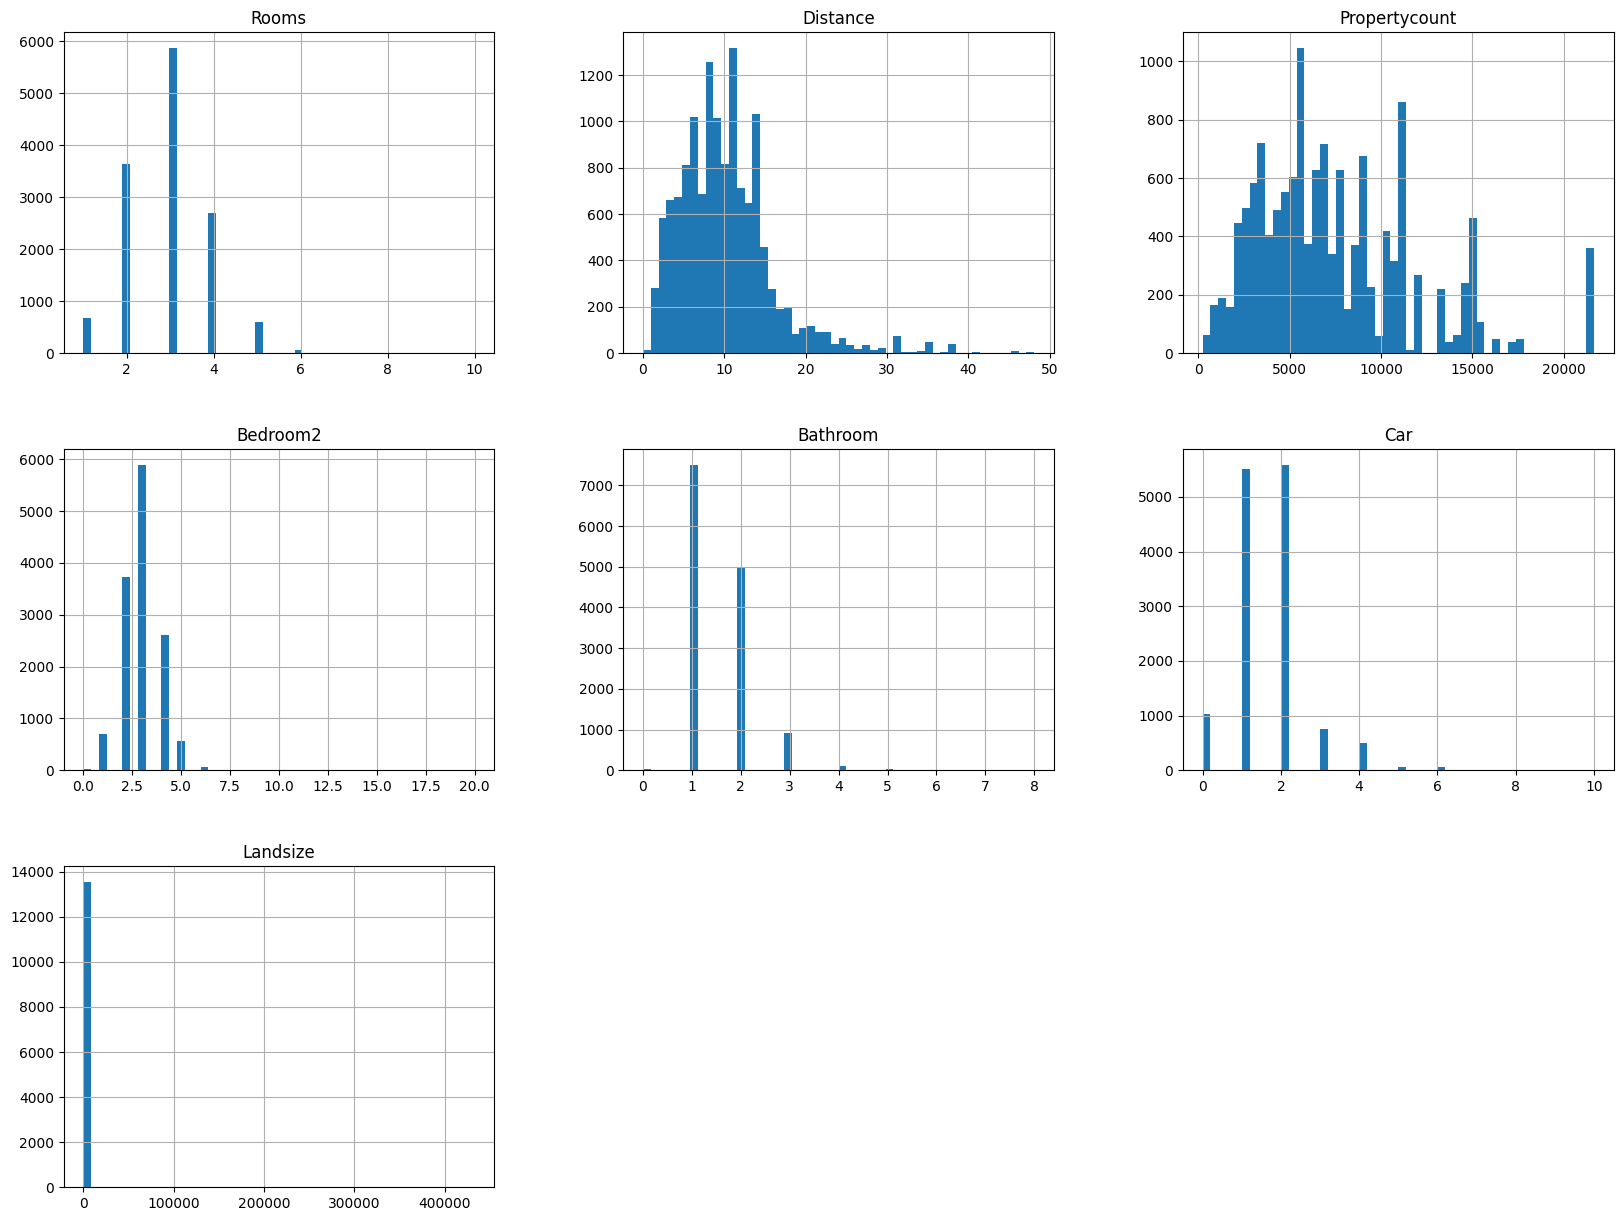

In [376]:
# Lets visualize the data
data.hist(bins=50, figsize=(20, 15))

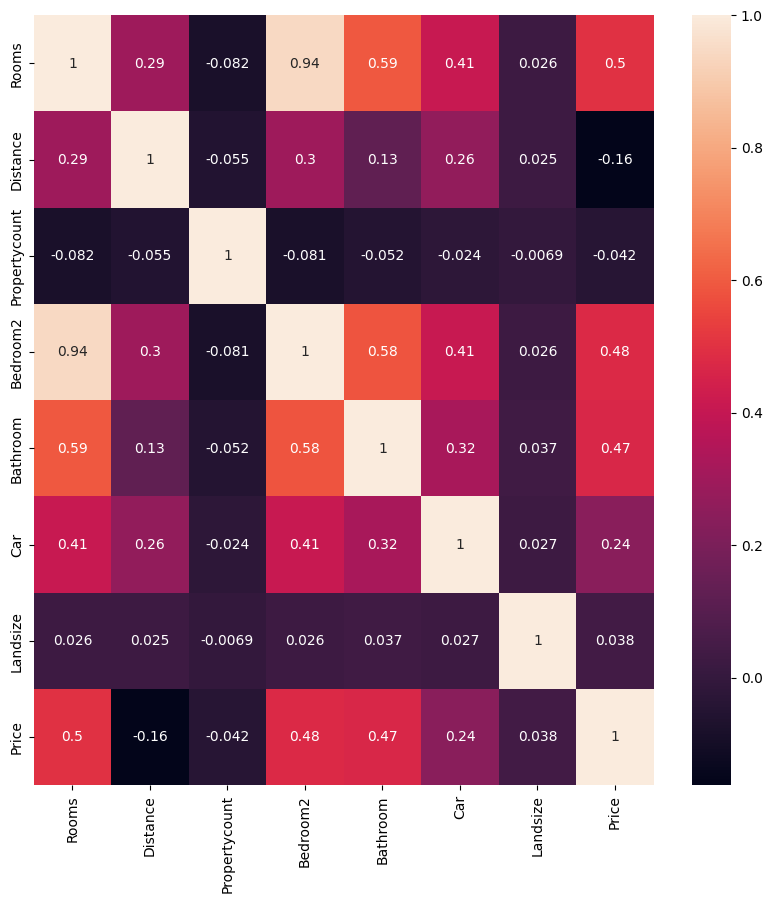

In [377]:
# Let's visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 10))

data_with_target = data.copy()
data_with_target[target_name] = target

sns.heatmap(data_with_target[numerical_features + [target_name]].corr(), annot=True)
plt.show()

We can see that Rooms and Bedroom2 are highly correlated. But also that Propertycount and Distance are negatively correlated with Price, so they might be good predictors. We can also see that Price is highly correlated with Rooms and Bedroom2 which makes sense since the more rooms a house has the more expensive it is.

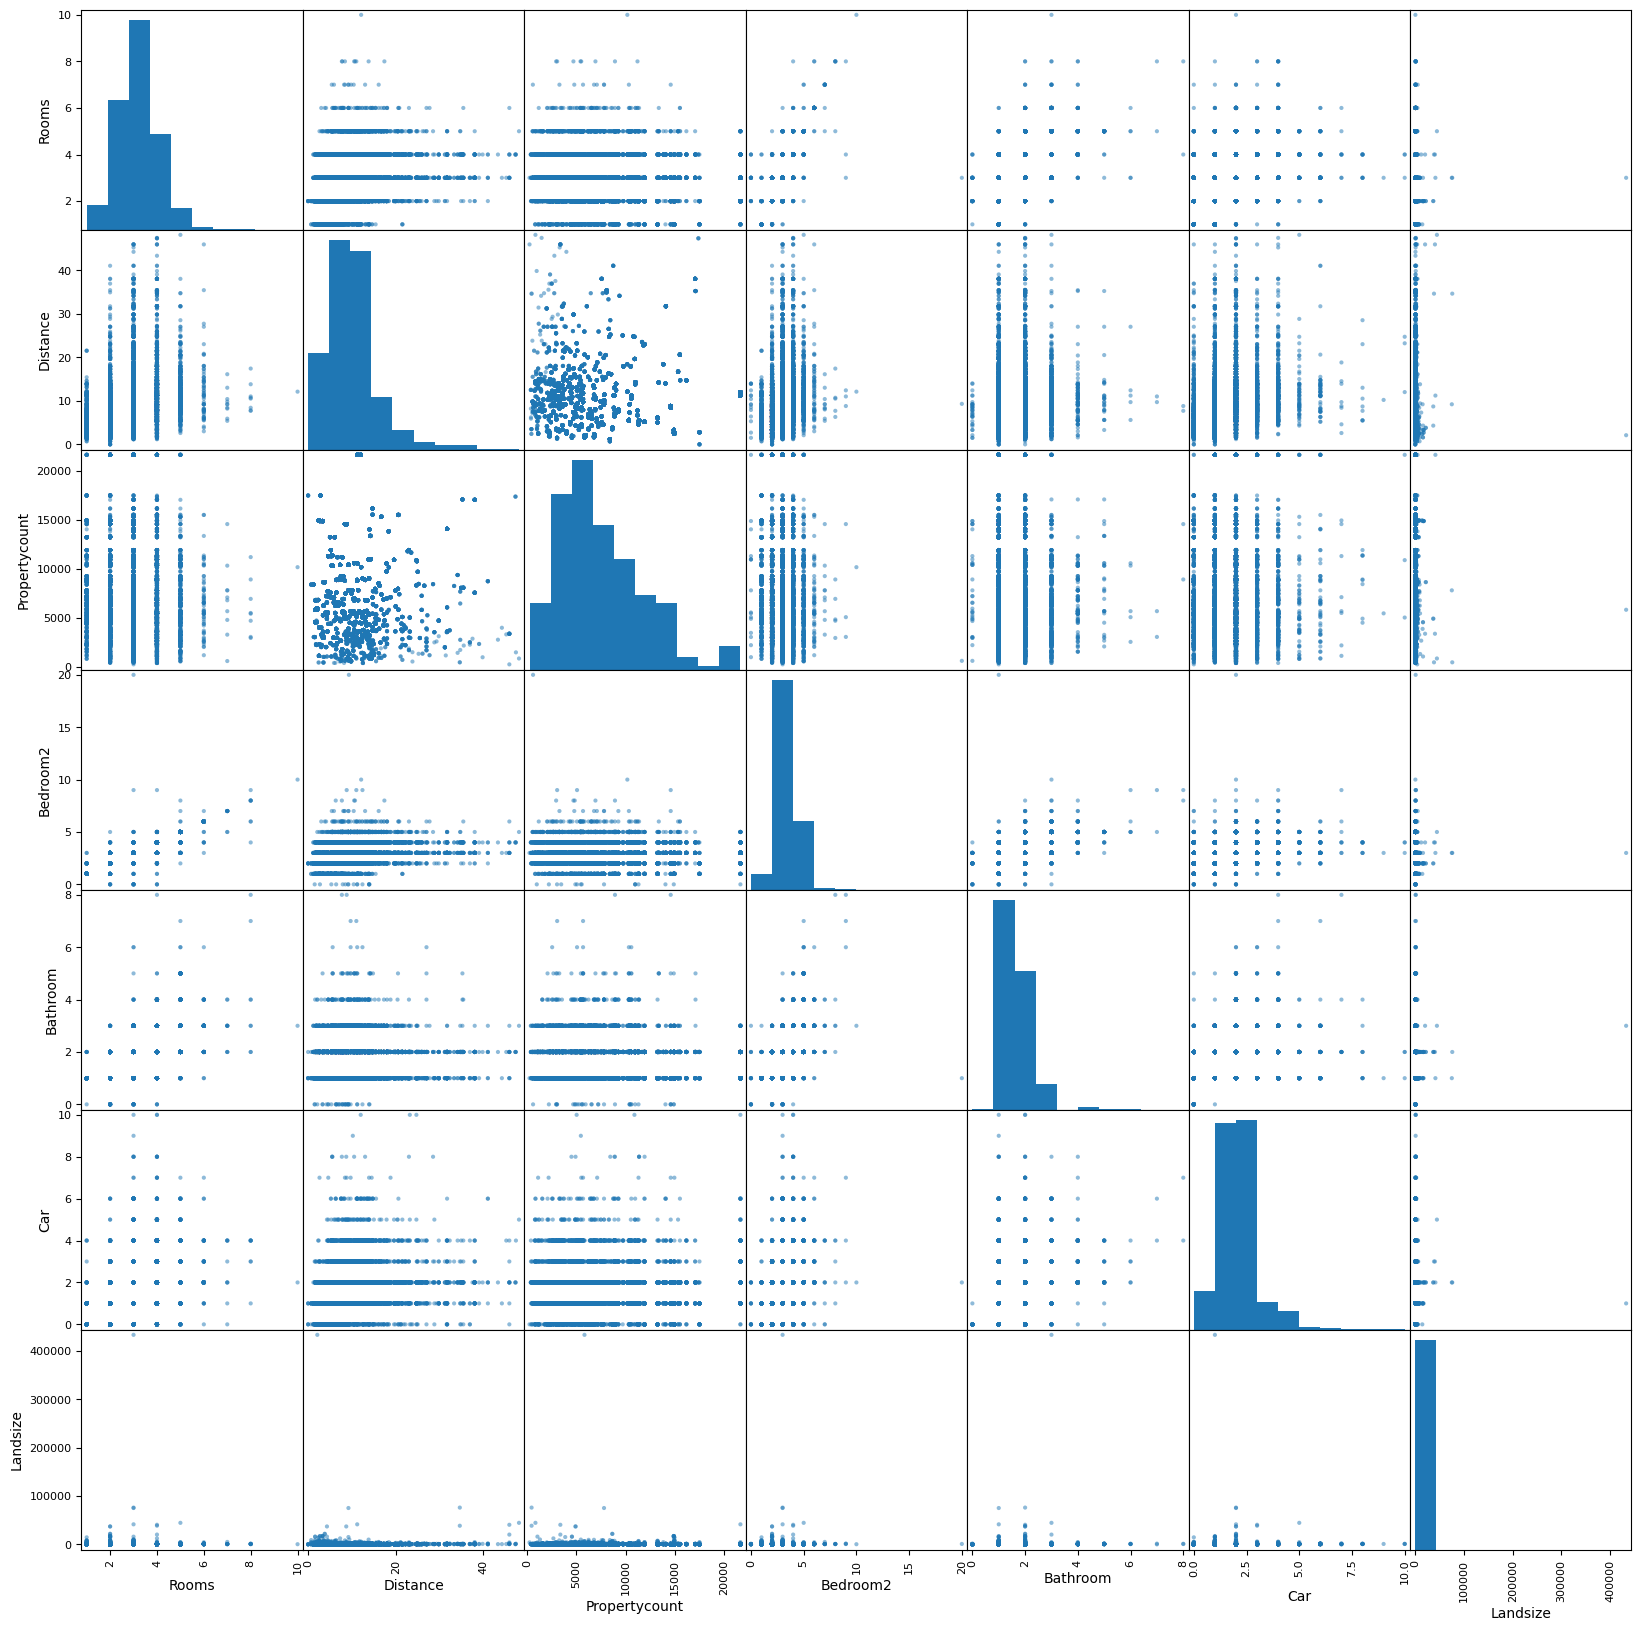

In [378]:
# Let's also visualize the scatter matrix of the numerical features
# It will help us see the distribution of the data
scatter_matrix(data[numerical_features], figsize=(20, 20))
plt.show()

We can see the same results as before, Rooms and Bedroom2 are highly correlated, and Propertycount and Distance are negatively correlated with Price. We can also see that Landsize has a long tail distribution, which means that there are some outliers in the data.

In [379]:
# Landsize seems to have a long tail distribution
data[["Landsize"]].describe()

,Landsize
count,13580.000000
mean,558.416127
std,3990.669241
min,0.000000
25%,177.000000
50%,440.000000
75%,651.000000
max,433014.000000


In [380]:
# If we remove the outliers we can see the distribution more clearly, but we will lose data, so we will keep the outliers

In [381]:
# We check all the columns with missing values
data.isna().mean() * 100

Rooms             0.000000
Distance          0.000000
Propertycount     0.000000
Bedroom2          0.000000
Bathroom          0.000000
Car               0.456554
Landsize          0.000000
Type              0.000000
SellerG           0.000000
Regionname        0.000000
CouncilArea      10.081001
dtype: float64

In [382]:
# We can see that Car column has missing values, we can use the most frequent value to fill the missing values
data["Car"].value_counts()

data["Car"] = data["Car"].fillna(data["Car"].mode()[0])

data.isna().mean() * 100

Rooms             0.000000
Distance          0.000000
Propertycount     0.000000
Bedroom2          0.000000
Bathroom          0.000000
Car               0.000000
Landsize          0.000000
Type              0.000000
SellerG           0.000000
Regionname        0.000000
CouncilArea      10.081001
dtype: float64

#### We create a pipeline to apply the transformations to the data

In [383]:

numerical_features_transformer = Pipeline(steps=[
    # ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
], verbose=True)

categorical_features_transformer = Pipeline(steps=[
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
], verbose=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_features_transformer, numerical_features),
        ("cat", categorical_features_transformer, categorical_features)
    ]
)

# We also need to define the classifier, which in this case is a Linear Regression model
classifier = LinearRegression()
# classifier = LogisticRegression()

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", classifier)
])

# Now we have a pipeline that can apply the transformations to the data

#### Splitting the data into training and testing sets

In [384]:
data.shape

(13580, 11)

In [385]:
target.shape

(13580,)

In [386]:
test_size = 0.2 # 20% of the data will be used for testing
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training target size: {y_train.shape}")
print(f"Testing target size: {y_test.shape}")

Training set size: (10864, 11)
Testing set size: (2716, 11)
Training target size: (10864,)
Testing target size: (2716,)


#### Applying the transformations to the training and testing sets

In [387]:
model.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 1) Processing encoder, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  ['Rooms', 'Distance',
                                                   'Propertycount', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))],
                                                           verbose=True),
                                                  ['Type', 'SellerG',
                                                   'Regionname',
                                                   'CouncilArea'])])),
                ('classifier', LinearRegression())])

#### Evaluating the model

In [388]:
X_train.head()

,Rooms,Distance,Propertycount,Bedroom2,Bathroom,Car,Landsize,Type,SellerG,Regionname,CouncilArea
5791,3,6.1,13240.0,3.0,2.0,2.0,128.0,t,McGrath,Southern Metropolitan,Port Phillip
6749,2,9.1,1543.0,2.0,1.0,1.0,0.0,u,Barry,Western Metropolitan,Moonee Valley
10626,1,6.7,3445.0,1.0,1.0,4.0,741.0,h,Raine,Northern Metropolitan,Moreland
5263,3,2.6,14949.0,3.0,2.0,1.0,115.0,h,hockingstuart,Northern Metropolitan,Yarra
11337,3,16.1,4790.0,3.0,2.0,2.0,239.0,t,Barry,Eastern Metropolitan,Manningham


In [389]:
y_train.head()

5791     1400000.0
6749      373000.0
10626     867000.0
5263     1600000.0
11337     920000.0
Name: Price, dtype: float64

In [390]:
from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {"preprocessor__num__imputer__strategy": ["mean"]},
#     # {"preprocessor__cat__imputer__strategy": ["most_frequent"]}
# ]
#
# cv = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error",
#                            verbose=2, n_jobs=8)
#
# cv.fit(X_train, y_train)

cv = cross_validate(model, X_train, y_train, cv=5, return_estimator=True, n_jobs=5, verbose=2)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.6s finished


In [391]:
# We can see the best parameters
# cv.best_params_
cv


{'fit_time': array([0.09103465, 0.07043695, 0.08300114, 0.07847786, 0.09003401]),
 'score_time': array([0.00955868, 0.01256418, 0.01057577, 0.00903177, 0.0115602 ]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('scaler',
                                                                     StandardScaler())],
                                                             verbose=True),
                                                    ['Rooms', 'Distance',
                                                     'Propertycount', 'Bedroom2',
                                                     'Bathroom', 'Car',
                                                     'Landsize']),
                                                   ('cat',
                                                    Pipeline(steps=[('encoder',
                                                 

In [392]:
# Let's evaluate the model on the test set
from sklearn.metrics import mean_squared_error

y_pred = cv["estimator"][0].predict(X_test)
mean_squared_error(y_test, y_pred)


176741108620.32013

In [393]:
#